# ELBO vs EULBO Comparison

A Python notebook regarding Gaussian Processes based primarily on the pre-prints of two papers: *Computation-Aware Gaussian Processes* and *Approximation-Aware Bayesian Optimization*.

## Problem Setup

We want to use Gaussian Process regression to perform Bayesian optimization to find $x^{*} = \arg\max_{x \in \mathcal{X}}f(x)$, for the unknown objective function $f(\cdot): \mathcal{X} \to \mathbb{R}$, for an unknown real-valued function defined on the **compact** domain $\mathcal{X} \subset \mathbb{R}^{d}$. Initially, we have some existing dataset $\mathcal{D}_{0} = \{(x_{i}, y_{i})\}_{i=1}^{n}$, with $x_{i} \in \mathbb{R}^{d}, y_{i} \in \mathbb{R}$.

Unfortunately, the standard `BayesOpt` formulation has $\mathcal{O}(n^3)$ time complexity, as the "proper" mathematical formulation requires a matrix inversion. To reduce the computational complexity, we include an "action matrix" $\mathbf{S}_{k} \in \mathbb{R}^{n \times k}$ for $k \ll n$ and performing Bayesian optimization on the "simplified" dataset $\mathcal{D}'_{0} = (\mathbf{S}_{k}^{\top}\mathbf{X}, \mathbf{S}_{k}^{\top}\mathbf{y})$, which yields $\mathcal{O}(kn^2)$ time complexity.

In this notebook, we provide an altered Variational Inference (VI) approach to this problem. The variational family $\mathcal{Q}_{n,k}$ of functions is indexed by the matrices (variational parameters) $\mathbf{S}_k \in \mathbb{R}^{n \times k}$.

## Goal

Beyond simply using the ELBO for the purposes of choosing a new action matrix and a new point for the dataset, we perform a joint optimization over the actions and new datapoints simultaneously, and this is done with a utility-weighted acquisition function (EULBO). 

The goal of this notebook is to compare the utility-weighted EULBO approach to ELBO-based approaches which do not incorporate a utility function and approaches for this maximization which perform individual acquisitions instead of optimizing over the new action(s) and new data point(s) in tandem.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch

try:
    import jaxtyping
except ImportError:
    %pip install jaxtyping

from typing import Optional, Tuple
# Type hints are strictly optional, but personally I find that they make code more reasonable

from jaxtyping import Float, Integer
from collections.abc import Callable
# This package allows type annotations that include the size of torch Tensors/numpy arrays
# It's not necessary, but it helps with understanding what each function does

from torch import Tensor

%matplotlib inline

# Set DTYPE and DEVICE variables for torch tensors
DTYPE = torch.float32
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

import torch
import tqdm.notebook as tqdm

# Set a seed (for reproducibility)
# torch.manual_seed(2024)

# Gaussian Process Setup

For convenience, we will use a prior mean function $\mu = 0$ and the [Matérn covariance function](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function) with $\nu = 5/2$ as the priors for our Bayesian optimization.

In [2]:
def mu(X: Float[Tensor, "N D"]) -> Float[Tensor, "N"]:
    r"""
    Computes the (very lame) zero mean function mu(X) = 0
    """

    return torch.zeros(*X.shape[:-1], dtype=X.dtype, device=X.device)

    # This return statement might seem like it's a pedantic way just to return the number 0 :)
    # It's not:
    # - if we want to compute a batch of GPs, the batch size of the returned zero
    #   tensor will match the batch size of X
    # - if X is a float64 tensor rather than float32, the returned zero tensor will match the correct dtype
    # - if X is on the GPU rather than the CPU, the returned zero tensor will also be on the same device

    # You don't always have to be this pedantic, but it's not a bad habit to get into

In [3]:
def matern_kernel(
    X1: Float[Tensor, "M D"], 
    X2: Float[Tensor, "N D"],
    ls: Float[Tensor, "1 D"], 
    os: Float[Tensor, "1 1"],
) -> Float[Tensor, "M N"]:
    r"""
    Computes Matern 5/2 kernel across all pairs of points (rows) in X1 & X2

    k(X1, X2) = os * (1 + \sqrt{5} * D + 5/3 * (D**2)) * exp(-\sqrt{5} * D)
    D = || (X1 - X2) / ls ||_2
    https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function

    ls: lengthscale
    os: outputscale
    """

    # Compute D, D ** 2, \sqrt{5} * D
    D_sq = (X1.div(ls).unsqueeze(-2) - X2.div(ls).unsqueeze(-3)).square().sum(dim = -1)
    # ^^^ This function is using broadcasting (via the unsqueeze operation)
    #     to compute all of the pairwise distances in parallel
    #
    #     You should also get into the habit of using "negative indexes"
    #     (i.e. unsqueeze(-2) rather than unsqueeze(0))
    #     as negative indices allow you to easily write parallel code for batched operations.
    #     (Again, not important now, but a good habit to develop!)
    
    D = torch.sqrt(D_sq + 1e-20)  # The 1e-20 is for numerical stability, so we don't get any NaNs if D≈0 but is very small and negative
    
    # Compute and return kernel
    return torch.mul(
        1 + (math.sqrt(5) * D) + ((5. / 3) * D_sq),
        torch.exp(-math.sqrt(5) * D)
    ).mul(os)

In [4]:
def compute_posterior_mean_and_variance(
    test_inputs: Float[Tensor, "M D"],
    X: Float[Tensor, "N D"],
    y: Float[Tensor, "N"],
    K_chol: Float[Tensor, "N N"],
    ls: Float[Tensor, "1 D"],
    os: Float[Tensor, "1 1"],
) -> tuple[Float[Tensor, "M"], Float[Tensor, "M M"]]:
    r"""
    Given inputs where we will evaluate the posterior, computes and returns the posterior moments
    - E[ f(test_inputs) | y ] = mu(test_inputs) + k(test_inputs, X) @ k(X, X)^{-1} @ (y - mu(X))
    - Cov[ f(test_inputs) | y ] = k(test_inputs, test_inputs) + k(test_inputs, X) @ k(X, X)^{-1} @ k(X, test_inputs)

    test_inputs:     the matrix containing test inputs we want to evaluate f() on
    X:               the matrix containing training inputs (where we have observations)
    y:               is the vector of training observations
    K_chol:          the Cholesky factor of the k(X, X) kernel matrix evaluated on training inputs
                     plus observational noise
                         i.e. K_chol @ K_chol.T = (k(X, X) + sigma^2 I)
    ls:              is the lengthscale of the kernel
    os:              is the outputscale of the kernel
    """

    # ^^^ Note:
    # You may be wondering why we are passing in K_chol,
    # rather than computing it as part of this function.
    # The reasoning will make sense once we start iteratively updating the posterior

    # Compute k(X, X)^{-1} k(X, test_inputs)
    # We need this term for both the posterior mean and posterior variance
    Ktest = matern_kernel(X, test_inputs, ls, os)
    K_inv_Ktest = torch.cholesky_solve(Ktest, K_chol, upper=False)

    # ***SUPER IMPORTANT:***
    # Note that we are using `cholesky_solve` to compute k(X, X)^{-1} k(X, test_inputs)
    # rather than calling k(X, X).inverse() @ Ktest
    # This is highly intentional
    # 1) Never call .inverse(); it is highly unstable. Always perform matrix solves instead.
    # 2) We can use the fact that k(X, X) is positive semi-definite to speed up solves.
    #    The way we exploit this is by first applying the Cholesky decomposition to k(X, X)
    #    (which exists because it is PSD) and then using it to perform a series of triangular
    #    solves (which are fast).

    # Compute posterior mean
    posterior_mean = mu(test_inputs) + (K_inv_Ktest.mT @ (y - mu(X)).unsqueeze(-1)).squeeze(-1)
    # Some notes:
    # 1) .mT is the same as .T, but it works with batched tensors
    #    i.e. it transposes the last two dimensions of the tensor
    #    this helper is useful if we want to use batched GPs
    # 2) (y - mu(X)).unsqueeze(-1) turns `y - mu(X)` from a N vector into a
    #    N x 1 matrix so that we can then use the matmul function with it.
    #    ().squeeze(-1) converts the resulting matmul back into a N vector.

    # Compute posterior covariance
    posterior_covar = matern_kernel(test_inputs, test_inputs, ls, os) - Ktest.mT @ K_inv_Ktest

    # Done!
    return posterior_mean, posterior_covar

In [5]:
def update_chol_newdata(
    K_chol: Float[Tensor, "N N"],
    X: Float[Tensor, "N D"],
    X_next: Float[Tensor, "N_next D"],
    ls: Float[Tensor, "1 D"],
    os: Float[Tensor, "1 1"],
    sigma_sq: Float[Tensor, ""],
    eps: float = 1e-4,
) -> Float[Tensor, "(N+N_next) (N+N_next)"]:
    """
    Computes the Cholesky factor of the block matrix
    [ k(X, X) + sigma_sq * I          k(X, X_next)                      ]
    [ k(X_next, X)                    k(X_next, X_next)  + sigma_sq * I ]
    where k is the kernel covariance

    This function should efficiently use prior computation.
    Given that we already have computed K_chol @ K_chol.T = k(X, X),
    we should be able to "update" that K_chol in O(N^2) time to get the
    desired block cholesky factorization.

    K_chol: Cholesky factorization of k(X, X) + sigma_sq * I
    X: Prior data
    X_next: Newly-added data
    ls: Length scale of the kernel covariance
    os: Output scale of the kernel covariance
    sigma_sq: Observation noise
    eps:      Small amount of noise to add to the diagonal for stability
    """

    # TODO: this function is currently not efficient :)
    # Right now, we're just computing the block Cholesky factorization from scratch,
    #     rather than reusing K_chol for an efficient update
    # You should make this function more efficient.

    X_joint = torch.cat([X, X_next], dim = -2)
    K_joint = matern_kernel(X_joint, X_joint, ls, os)

    # Add sigma_sq * I to K_joint
    #
    # *Important*: the Cholesky factorization can be a bit numerically unstable
    # If the smallest eigenvalues of K are ≈0, they can numerically appear to be slightly negative
    #     which causes the Cholesky factorization to fail
    # We can circumvent this problem by adding a small amount of diagonal noise to K_joint
    #     to bump up all of the eigenvalues
    I = torch.eye(K_joint.size(-1), dtype=K_joint.dtype, device=K_joint.device)
    K_joint = K_joint + (sigma_sq + eps) * I

    # Now we're ready to compute the Cholesky factor
    # return torch.linalg.cholesky(K_joint, upper=False)

    # Get the sub-blocks of K_joint
    N = X.shape[0]
    N_next = X_next.shape[0]
    K_11, K_12, K_22 = K_joint[0:N, 0:N], K_joint[0:N, N:], K_joint[N:, N:]

    # Cholesky factorization on the sub-blocks
    L_21 = torch.linalg.solve_triangular(K_chol, K_12, upper = False).mT
    L_22 = torch.linalg.cholesky(K_22 - L_21 @ L_21.mT, upper = False)

    # Concatenate sub-blocks of Cholesky decomposition matrix and return them in the form
    # [ K_chol      0 ]
    # [ L_21     L_22 ]
    return torch.cat(
        (torch.cat((K_chol, torch.zeros(N, N_next)), dim = -1), 
         torch.cat((L_21, L_22), dim = -1)
        ), dim = -2)

# Test Functions

We will use a few test functions to compare the performance of various Bayesian Optimization algorithms.

These include:
- The ["Hartmann 6" function](https://www.sfu.ca/~ssurjano/hart6.html) defined on $[0, 1]^{6}$.

In [6]:
def simple_periodic(X: Float[Tensor, "N 1"]) -> Float[Tensor, "N"]:
    r"""
    Computes values of f(x) = sin(2pi*x) + sin(4pi*x)
    """

    ### TODO: Check if inputs are "valid" (possibly)

    return X[:, 0].mul(2 * math.pi).sin() + X[:, 0].mul(4 * math.pi).sin()  
    

In [7]:
def hartmann_six(X: Float[Tensor, "N 6"]) -> Float[Tensor, "N"]:
    r"""
    Computes the value of the Hartmann six-dimensional test function on N rows of input data
    More info on this test function at: https://www.sfu.ca/~ssurjano/hart6.html
    """

    ### TODO: Check if inputs are "valid" (possibly)
    
    alpha = torch.tensor([1.0, 1.2, 3.0, 3.2], dtype = DTYPE, device = X.device)
    A = torch.tensor([[10, 3, 17, 3.5, 1.7, 8],
                      [0.05, 10, 17, 0.1, 8, 14],
                      [3, 3.5, 1.7, 10, 17, 8],
                      [17, 8, 0.05, 10, 0.1, 14]],
                     dtype = DTYPE, device = X.device)
    P = 1e-4 * torch.tensor([[1312, 1696, 5569, 124, 8283, 5886],
                             [2329, 4135, 8307, 3736, 1004, 9991],
                             [2348, 1451, 3522, 2883, 3047, 6650],
                             [4047, 8828, 8732, 5743, 1091, 381]], 
                            dtype = DTYPE, device = X.device)

    # Calculate "inner sums" 
    inner_sums: Float[Tensor, "N 4"] = torch.sum(A * (X.unsqueeze(-2) - P).pow(2), -1)

    # Exponentiate and compute "outer sums"
    outer_sums: Float[Tensor, "N"] = alpha @ torch.exp(-inner_sums).mT
    
    return outer_sums

In [8]:
def observe(
    func: Callable[[Float[Tensor, "N D"]], Float[Tensor, "N"]],
    X: Float[Tensor, "N D"], 
    sigma_sq: Float = 1e-2,
) -> Float[Tensor, "N"]:
    r"""
    A "wrapper" to return y = func(X) + noise.

    func: A real-valued function defined on R^D which is applied row-wise to X
    X: A matrix of N D-dimensional real-valued inputs to the function
    sigma_sq: Variance of the IID observation noise 
    """
    
    true_obs = func(X)
    return true_obs + torch.randn_like(true_obs).mul(math.sqrt(sigma_sq))

In [9]:
# Ensuring the observe function works as intended
# test_vecs = torch.rand(9, 6)
# true_vals = hartmann_six(test_vecs)
# obs_vals = observe(hartmann_six, test_vecs, sigma_sq = 1e-6) # Should be pretty similar.
# print(true_vals)
# print(obs_vals)
# print(true_vals - obs_vals)

# # Global optimum of the Hartmann 6D function
# H6_argmax = torch.tensor([[0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573]])
# H6_globalmax = hartmann_six(H6_argmax)

# Acquisition

The acquisition function which we utilize here is the EULBO; a utility-weighted version of the standard ELBO (Evidence Lower BOund) for variational inference which also includes a utility function.

In this setting, we have the following:
- $f(\cdot): \mathcal{X} \to \mathbb{R}$: A real-valued function defined on the **compact** set $\mathcal{X} \subset \mathbb{R}^{d}$. 
- $\mathcal{D}$: A dataset of observations $\{(x_{i}, y_{i})\}_{i=1}^{n}$, of the form $y_{i} = f(x_{i}) + \epsilon_{i}$, where $x_{i} \in \mathcal{X} \subset \mathbb{R}^{d}, y_{i} \in \mathbb{R}$.
- $\mathcal{Q}$, a variational family of functions indexed by matrices $\mathbb{S} \in \mathbb{R}^{n \times k}$.
- $u(x_{\textrm{new}}, f; \mathcal{D}): \mathbb{R}^{d} \to \mathbb{R}$: A utility function for choosing $x_{\textrm{new}} \in \mathbb{R}^{d}$.

## EULBO

Defining the **expected utility** function $\alpha(\mathbf{x}; \mathcal{D}) = \int u(x, f; \mathcal{D})p(f \mid \mathcal{D})\textrm{d}f$ yields the EULBO inequality:  $$\log(\alpha(\mathbf{x}, \mathcal{D})) \ge \mathbb{E}_{q_{\mathbf{S}}}\left[\log\left(\frac{p(f, \mathcal{D}_{t})}{q_{\mathbf{S}}(f)}\right)\right] + \mathbb{E}_{q_{\mathbf{S}}}\left[\log\left({u(x, f; \mathcal{D}_{t})}\right)\right] - \log(Z)$$

This is the sum of the ELBO and the expected log-utility, with an additional constant term which we conveniently ignore, as we are maximizing the EULBO with respect to $(\mathbf{S}, x_{\textrm{new}})$ so this constant is not a concern as we do not care about the value of the bound outright.

## Utility Functions

There are several utility functions which may be useful for this goal. As we work with the expected log-utility, we must ensure that these functions are strictly positive. Possible utility functions include the following:
- "Soft" Expected Improvement: $u_{\textrm{SEI}}(x_{\textrm{new}}, f, \mathcal{D}) = \log(1 + \exp(f(x_{\textrm{new}}) - y_{\textrm{best}}))$
- Z-Scored EI: $u_{\textrm{ZEI}}(x_{\textrm{new}}, f, \mathcal{D}) = \log\left(1 + \exp\left(\frac{f(x_{\textrm{new}}) - y_{\textrm{best}})}{\sigma(x_{\textrm{new}})}\right)\right)$, which is similar to $u_{\textrm{SEI}}$ but with the difference weighted by the *approximate* standard deviation of $f(x_{\textrm{new}})$.

In [119]:
def EULBO(
    S: Float[Tensor, "N T"],
    x_new: Float[Tensor, "1 D"],
    X: Float[Tensor, "N D"],
    y: Float[Tensor, "N"],
    K_chol: Float[Tensor, "N N"],
    n_sample: Integer = 1000
) -> Float[Tensor, " "]:
    """
    A function to compute the EULBO for an action matrix S and a datapoint x_new
    based on observations from the existing dataset D = (X, y).

    Parameters
    S: A provied N-by-T action matrix (T << N)
    x_new: A new input, where f(x_new) is defined
    X: The "input values" in the observed dataset
    y: The corresponding "outputs" for the observed dataset
    K_chol: Cholesky decomposition of k(X, X) + sigma_sq * I

    Global Constants     
    ls: length scale of inputs
    os: output scale
    sigma_sq: Variance of observation noise

    Returns
    ELBO: The ELBO corresponding to conditioning on S'X and S'y
    """
    
    # Cholesky decomposition of S'(K + sigma^2 I)S
    try:
        STKS_chol: Float[Tensor, "T T"] = torch.linalg.cholesky(S.mT @ K_chol @ K_chol.mT @ S)
    except:
        return torch.tensor([-1000])

    return ELBO(S, X, y, K_chol, STKS_chol) + mean_log_utility(S, x_new, X, y, STKS_chol, n_sample)

From the Supplementary Material in the Computation Aware paper, we have that for an action matrix $\mathbf{S}_{t} \in \mathbb{R}^{n \times t}$, the ELBO is given by 
$$\ell_{\textrm{IterGP}}^{\textrm{ELBO}} = \frac{1}{2}\left(\frac{1}{\sigma^{2}}\lVert \mathbf{y} - \mu_{t}(\mathbf{X})\rVert_{2}^{2} +\sum_{j=1}^{n}K_{t}(x_{j}, x_{j}) + n\log(2\pi\sigma^2) - t\log(\sigma^2) + \mathbf{y}^{\top}\mathbf{S}_{t}(\mathbf{S}_{t}^{\top}(\mathbf{K}+\sigma^{2}\mathbf{I})\mathbf{S}_{t})^{-1}\mathbf{S}_{t}^{\top}\mathbf{K}\mathbf{S}_{t}(\mathbf{S}_{t}^{\top}(\mathbf{K}+\sigma^{2}\mathbf{I})\mathbf{S}_{t})^{-1}\mathbf{S}_{t}^{\top}\mathbf{y} - \textrm{tr}\left(\left(\mathbf{S}_{t}^{\top}(\mathbf{K}+\sigma^{2}\mathbf{I})\mathbf{S}_{t}\right)^{-1}\mathbf{S}_{t}^{\top}\mathbf{K}\mathbf{S}_{t}\right) + \log\det\left(\mathbf{S}_{t}^{\top}(\mathbf{K}+\sigma^{2}\mathbf{I})\mathbf{S}_{t}\right) - \log\det\left(\mathbf{S}_{t}^{\top}\mathbf{S}_{t}\right)\right)$$

In [120]:
def ELBO(
    S: Float[Tensor, "N T"],
    X: Float[Tensor, "N D"],
    y: Float[Tensor, "N"],
    K_chol: Float[Tensor, "N N"],
    STKS_chol: Float[Tensor, "T T"]
) -> Float[Tensor, " "]:
    """
    A function to compute the ELBO for action matrix S based on the existing dataset D = (X, y).

    Parameters
    S: A queried action matrix 
    X: The "input values" in the observed dataset
    y: The corresponding "outputs" for the observed dataset
    K_chol: Cholesky decomposition of k(X, X) + sigma_sq * I
    STKS_chol: Cholesky decomposition of S'(k(X, X) + sigma_sq * I)S

    Global Constants     
    ls: length scale of inputs
    os: output scale
    sigma_sq: Variance of observation noise

    Returns
    ELBO: The ELBO corresponding to conditioning on S'X and S'y
    """

    # Get posterior of f | S'X, S'y
    post_mean, post_var = compute_posterior_mean_and_variance(X, S.mT @ X, S.mT @ y, STKS_chol, ls, os)

    # C = S (S'(K + sigma_sq * I)S)^(-1) S'
    C = S @ torch.cholesky_solve(S.mT, STKS_chol)

    # Add up the individual terms
    ELBO = 0.5 * (
        (y - post_mean).square().sum().div(sigma_sq) +
        post_var.trace() +
        S.shape[0] * math.log(2 * math.pi * sigma_sq) - S.shape[1] * math.log(sigma_sq) + 
        y @ C @ (K_chol @ K_chol.mT - sigma_sq * torch.eye(K_chol.shape[0])) @ C @ y -
        torch.cholesky_solve(STKS_chol @ STKS_chol.mT - sigma_sq * S.mT @ S, STKS_chol).trace() +
        torch.linalg.slogdet(STKS_chol @ STKS_chol.mT).logabsdet - torch.linalg.slogdet(S.mT @ S).logabsdet
    )
    return ELBO.view(1).squeeze(-1)

In [12]:
def mean_log_utility(
    S: Float[Tensor, "N T"],
    x_new: Float[Tensor, "1 D"],
    X: Float[Tensor, "N D"],
    y: Float[Tensor, "N"],
    STKS_chol: Float[Tensor, "T T"],
    n_sample: Integer = 1000
) -> Float[Tensor, " "]:
    """
    A function to estimate the expected log utility for an action matrix S and a datapoint x_new
    based on observations from the existing dataset D = (X, y).

    Parameters
    S: A provied N-by-T action matrix (T << N)
    x_new: A new input, where f(x_new) is defined
    X: The "input values" in the observed dataset
    y: The corresponding "outputs" for the observed dataset
    STKS_chol: Cholesky decomposition of S'(k(X, X) + sigma_sq * I)S

    Global Constants     
    ls: length scale of inputs
    os: output scale
    sigma_sq: Variance of observation noise

    Returns
    mean_log_util: The average log utility (uSEI) corresponding to conditioning on S'X and S'y
    """
    # Monte Carlo samples to estimate expected log utility

    # Compute the variational inference distribution q_S(f) = f|(S'D) at x_new
    VI_mean, VI_var = compute_posterior_mean_and_variance(x_new, S.mT @ X, S.mT @ y, STKS_chol, ls, os)

    # Get standard normal samples and reparametrize
    z_samples: Float[Tensor, "n_sample"] = torch.normal(0, 1, size = (n_sample,))
    VI_samples = VI_mean + VI_var.diag().sqrt() * z_samples # reparametrization trick

    # Estimate softplus(expected improvement)
    y_best = y.max()
    uSEI = (VI_samples - y_best).exp().log1p() # softplus
    mean_log_util = uSEI.log().mean() 

    return mean_log_util.view(1).squeeze(-1)

# Algorithm Comparison

Lastly, we will compare two separate optimization schemes for this problem. These optimization schemes are:
1. Joint Optimization: $(\mathbf{S}_{t + 1}, {x}_{t+1}) = \arg\max_{(\mathbf{S}, x)}\left(\texttt{EULBO}(\mathbf{S}, {x}, \mathbf{X}_{1:t}, \mathbf{y}_{1:t})\right)$
2. Separate Optimization: $\mathbf{S}_{t + 1} = \arg\max_{\mathbf{S}}\texttt{ELBO}(\mathbf{S}, \mathbf{X}_{1:t}, \mathbf{y}_{1:t})$ and $x_{t+1} = \arg\max_{x \in \mathcal{X}}\mathbb{E}_{Q_{\mathbf{S}_{t}}}\left[\log(u(x; f, \mathbf{X}_{1:t}, \mathbf{y}_{1:t}))\right]$

In [13]:
# Helper function to ensure that each column of the matrix has an L2 norm of 1 

def normalize_cols(S: Float[Tensor, "R C"]) -> Float[Tensor, "R C"]:
    # Calculate L2 norms of columns of the given matrix
    col_norms: Float[Tensor, "C"] = (S * S).sum(-2).sqrt()

    # Error checking to avoid division by 0
    if 0. in col_norms:
        raise Exception("Error: One or more columns of the provided matrix has a norm of zero.")

    # Divide column-wise by the L2 norm
    return torch.div(S, col_norms)

In [231]:
D: Integer = 6  # Dimension of function input space
N: Integer = 100 # Initial dataset size

# GP hyperparameters (global):
#   - ls: kernel lengthscale
#   - os: kernel outputscale
#   - sigma_sq: observational noise
ls: Float[Tensor, "1 D"] = torch.ones((1, D), dtype = DTYPE, device = DEVICE)
os: Float[Tensor, "1 1"] = torch.tensor(1., dtype = DTYPE, device = DEVICE).view(1, 1)
sigma_sq: Float[Tensor, "1 1"] = torch.tensor(1e-2, dtype = DTYPE, device = DEVICE).view(1, 1)

## Simulations

In [282]:
# Setup
n_simulation = 10
n_epochs = 10

simulation_dict = {
    "Method": [], 
    "Simulation": [], 
    "Epoch": [], 
    "yBest": []
}

## Joint Optimization

Select $(\mathbf{S}_{n+1}, x_{n+1})$ using the EULBO.

In [191]:
# Joint Optimization over 
for sim in range(n_simulation):
    # Simulate dataset 
    X = torch.rand(N, D)
    y = observe(hartmann_six, X, sigma_sq)
    K_chol = torch.linalg.cholesky(matern_kernel(X, X, ls, os) + (sigma_sq + 1e-4) * torch.eye(N)) # epsilon = 1e-4

    simulation_dict["Method"].append("Joint")
    simulation_dict["Simulation"].append(sim + 1)
    simulation_dict["Epoch"].append(0)
    simulation_dict["yBest"].append(y.max().item())

    for epoch in range(n_epochs):
        # Initialize S and x_new arbitrarily
        S = normalize_cols(torch.rand(X.shape[0], 2))
        x_new = torch.rand(1,D)
        
        S_opt = torch.nn.Parameter(S)
        x_opt = torch.nn.Parameter(x_new)
        gain = torch.zeros(1, requires_grad = True)
        optimizer = torch.optim.Adam(params = [S_opt, x_opt], lr = 0.001, maximize = True)
        iterator = tqdm.tqdm(range(500), leave = False)
        
        for _ in iterator:
            gain = EULBO(S_opt, x_opt, X, y, K_chol)
            gain.backward()
            optimizer.step()
            # optimizer.zero_grad()
            iterator.set_postfix(gain = gain.item())
            
            # Clamp to avoid really large values 
            S = torch.clamp(S, min = -math.pow(N, -1/4), max = math.pow(N, -1/4))
            x_new = torch.clamp(x_new, min = 0, max = 1)

        # Update data 
        K_chol = update_chol_newdata(K_chol, X, x_new, ls, os, sigma_sq)
        y_new = observe(hartmann_six, x_new, sigma_sq)
        X = torch.cat([X, x_new], -2)
        y = torch.cat([y, y_new], -1)

        # Record info for the epoch
        simulation_dict["Method"].append("Joint")
        simulation_dict["Simulation"].append(sim + 1)
        simulation_dict["Epoch"].append(epoch + 1)
        simulation_dict["yBest"].append(y.max().item())

    # Printing progress update
    print(f"Completed {n_epochs} epochs for simulation {sim + 1}!")

  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 1 for simulation 1!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 2 for simulation 1!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 3 for simulation 1!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 4 for simulation 1!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 5 for simulation 1!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 6 for simulation 1!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 7 for simulation 1!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 8 for simulation 1!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 9 for simulation 1!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 10 for simulation 1!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 1 for simulation 2!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 2 for simulation 2!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 3 for simulation 2!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 4 for simulation 2!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 5 for simulation 2!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 6 for simulation 2!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 7 for simulation 2!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 8 for simulation 2!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 9 for simulation 2!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 10 for simulation 2!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 1 for simulation 3!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 2 for simulation 3!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 3 for simulation 3!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 4 for simulation 3!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 5 for simulation 3!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 6 for simulation 3!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 7 for simulation 3!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 8 for simulation 3!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 9 for simulation 3!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 10 for simulation 3!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 1 for simulation 4!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 2 for simulation 4!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 3 for simulation 4!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 4 for simulation 4!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 5 for simulation 4!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 6 for simulation 4!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 7 for simulation 4!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 8 for simulation 4!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 9 for simulation 4!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 10 for simulation 4!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 1 for simulation 5!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 2 for simulation 5!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 3 for simulation 5!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 4 for simulation 5!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 5 for simulation 5!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 6 for simulation 5!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 7 for simulation 5!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 8 for simulation 5!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 9 for simulation 5!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 10 for simulation 5!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 1 for simulation 6!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 2 for simulation 6!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 3 for simulation 6!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 4 for simulation 6!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 5 for simulation 6!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 6 for simulation 6!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 7 for simulation 6!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 8 for simulation 6!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 9 for simulation 6!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 10 for simulation 6!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 1 for simulation 7!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 2 for simulation 7!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 3 for simulation 7!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 4 for simulation 7!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 5 for simulation 7!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 6 for simulation 7!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 7 for simulation 7!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 8 for simulation 7!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 9 for simulation 7!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 10 for simulation 7!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 1 for simulation 8!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 2 for simulation 8!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 3 for simulation 8!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 4 for simulation 8!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 5 for simulation 8!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 6 for simulation 8!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 7 for simulation 8!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 8 for simulation 8!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 9 for simulation 8!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 10 for simulation 8!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 1 for simulation 9!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 2 for simulation 9!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 3 for simulation 9!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 4 for simulation 9!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 5 for simulation 9!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 6 for simulation 9!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 7 for simulation 9!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 8 for simulation 9!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 9 for simulation 9!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 10 for simulation 9!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 1 for simulation 10!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 2 for simulation 10!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 3 for simulation 10!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 4 for simulation 10!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 5 for simulation 10!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 6 for simulation 10!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 7 for simulation 10!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 8 for simulation 10!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 9 for simulation 10!


  0%|          | 0/500 [00:00<?, ?it/s]

Completed epoch 10 for simulation 10!


## Separate Optimization

Select $\mathbf{S}_{n+1}$ using ELBO and separately select $x_{n+1}$ using the maximum log utility.

In [283]:
for sim in range(n_simulation):
    # Simulate dataset 
    X = torch.rand(N, D)
    y = observe(hartmann_six, X, sigma_sq)
    K_chol = torch.linalg.cholesky(matern_kernel(X, X, ls, os) + (sigma_sq + 1e-4) * torch.eye(N)) # epsilon = 1e-4

    simulation_dict["Method"].append("Separate")
    simulation_dict["Simulation"].append(sim + 1)
    simulation_dict["Epoch"].append(0)
    simulation_dict["yBest"].append(y.max().item())

    for epoch in range(n_epochs):
        # Initialize S and x_new arbitrarily
        S = normalize_cols(torch.rand(X.shape[0], 2))
        x_new = torch.rand(1,D)
        
        S_opt = torch.nn.Parameter(S)
        S_curr = S_opt.data
        x_opt = torch.nn.Parameter(x_new)
        
        gain_S = torch.zeros(1, requires_grad = True)
        gain_x = torch.zeros(1, requires_grad = True)
        
        optimizer_S = torch.optim.Adam(params = [S_opt], lr = 0.001, maximize = True)
        optimizer_x = torch.optim.Adam(params = [x_opt], lr = 0.001, maximize = True)       

        iterator = tqdm.tqdm(range(500), leave = False)
        
        # iterator_S = tqdm.tqdm(range(500), leave = False)
        # iterator_x = tqdm.tqdm(range(500), leave = False)

        for _ in iterator:
            STKS_chol = torch.linalg.cholesky(S_opt.mT @ K_chol @ K_chol.mT @ S_opt)

            gain_x = mean_log_utility(S_curr, x_opt, X, y, STKS_chol)
            gain_x.backward(retain_graph=True)
            optimizer_x.step()

            # Clamp to avoid really large values
            x_new = torch.clamp(x_new, min = 0, max = 1)
            
            gain_S = ELBO(S, X, y, K_chol, STKS_chol)
            gain_S.backward(retain_graph = True)
            optimizer_S.step()
            S_curr = S.data

            # Clamp to avoid really large values
            S = torch.clamp(S, min = -math.pow(N, -1/4), max = math.pow(N, -1/4))

            iterator.set_postfix(gain = gain_S.item() + gain_x.item())

        # Update data 
        K_chol = update_chol_newdata(K_chol, X, x_new, ls, os, sigma_sq)
        y_new = observe(hartmann_six, x_new, sigma_sq)
        X = torch.cat([X, x_new], -2)
        y = torch.cat([y, y_new], -1)

        # Record info for the epoch
        simulation_dict["Method"].append("Separate")
        simulation_dict["Simulation"].append(sim + 1)
        simulation_dict["Epoch"].append(epoch + 1)
        simulation_dict["yBest"].append(y.max().item())

    # Printing progress update
    print(f"Completed {n_epochs} epochs for simulation {sim + 1}!")

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Completed 10 epochs for simulation 1!


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Completed 10 epochs for simulation 2!


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Completed 10 epochs for simulation 3!


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Completed 10 epochs for simulation 4!


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Completed 10 epochs for simulation 5!


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Completed 10 epochs for simulation 6!


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Completed 10 epochs for simulation 7!


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Completed 10 epochs for simulation 8!


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Completed 10 epochs for simulation 9!


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Completed 10 epochs for simulation 10!


## Plotting Simulation Results

In [284]:
import pandas as pd
import seaborn as sns

# sim_df = pd.DataFrame(simulation_dict)
# sim_df.to_csv("./Separate_Simulation_Results.csv", index = False)

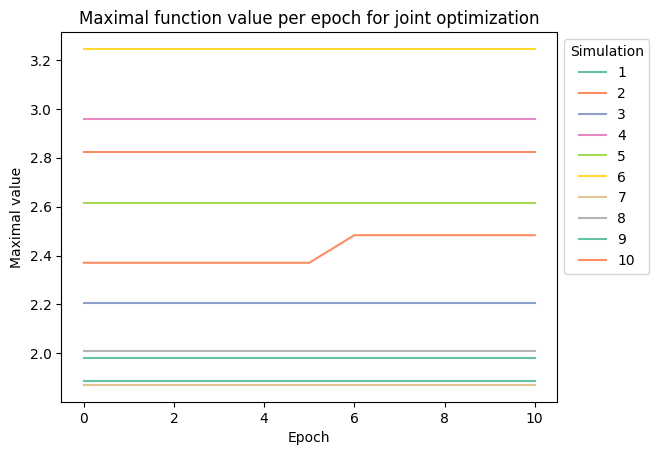

In [286]:
joint_sim_df = pd.read_csv("./Joint_Simulation_Results.csv")
ax = sns.lineplot(data = joint_sim_df, x = "Epoch", y = "yBest", 
                    hue = "Simulation", palette = "Set2")
ax.set_title("Maximal function value per epoch for joint optimization")
ax.set_ylabel("Maximal value")
sns.move_legend(ax, "upper left", bbox_to_anchor = (1,1))

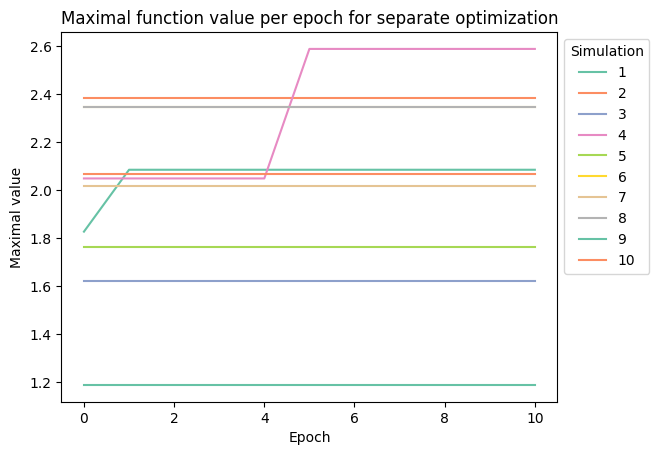

In [285]:
sepa_sim_df = pd.read_csv("./Separate_Simulation_Results.csv")
ax = sns.lineplot(data = sepa_sim_df, x = "Epoch", y = "yBest", 
                    hue = "Simulation", palette = "Set2")
ax.set_title("Maximal function value per epoch for separate optimization")
ax.set_ylabel("Maximal value")
sns.move_legend(ax, "upper left", bbox_to_anchor = (1,1))

# TODO:

- Optimize $\log p(\mathbf{y}; \sigma^2, \texttt{ls}, \texttt{os})$ instead of treating them as global constants
- Fix up the ELBO/EULBO function
- Fix numerical instability in EULBO calculation (try/catch when computing STKS_chol
- Use "raw" parameter values and transform them instead of performing inplace transformations on the optimized parameters
- Increase simulation size, number of projectons, etc.
- Make nicer plots!!!